In [1]:
# import packages

import pickle, pprint
import numpy as np

In [2]:
# load data

pkl_file = open('zo1_graph_timelapse_sample_v2.pkl','rb')
data1 = pickle.load(pkl_file)

# Data Visualization

In [3]:
# choose time step
# 12, 13 seems difficult
# couple of difficult ones. Need to rethink how to go about this
# Difficult ones - 1,2, 3
t = 11

Number of branches is  67
Number of nodes is  134


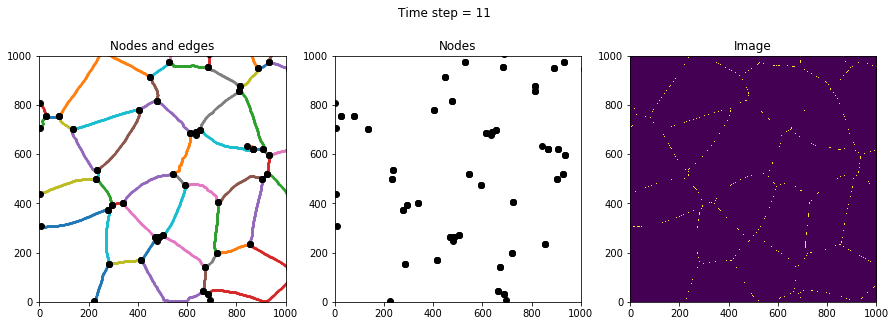

In [4]:
# plot edge, node and image data at time step t

import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

# plot nodes and edges
posit = [i for i in range(len(data1[2][t]))]

for pos in posit:
    l = len(data1[2][t][pos][:])-1
    # all edges/branches
    ax.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.', markersize = 2)
    
    # nodes (endpoints)
    ax.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
    ax.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')

# plot nodes
for pos in posit:
    l = len(data1[2][t][pos][:])-1
    ax2.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0],'ok')
    ax2.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0],'ok')

# plot image
img = ndimage.rotate(data1[0][t] == 2, 0)
# plot the image with origin at lower left
ax3.imshow(img, origin = 'lower')

titles = ['Nodes and edges','Nodes', 'Image' ]
# axis stuff
axes = list([ax, ax2, ax3])
for j,ax in enumerate(axes):
    ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
    ax.set_title(titles[j])

fig.suptitle("Time step = %d" %t , fontsize=12)
print('Number of branches is ', len(posit))
print('Number of nodes is ', 2*len(posit))

# Curve fitting + Data post processing

Now we put the nodes and edges into our data structure and perform curve fits to find radius

Theres a lot of nodes stacked on top of each other. We have to group nodes together if they are really really close

What we do here is check the normalized distance of a node from all the other nodes in a list that we are constantly appending. If the distance is more than a cutoff, then we make a new node. If its less than a cutoff, then we replace that node with the closest node to it in the list. 

We only add a new branch if the node_a and node_b selected after the above process for a branch are not the same

In [9]:
# choose cutoff distance (minimum normalized distance between nodes)
# change this value if error -> impossible arc asked for, radius too small

# Try 60 
cutoff = 60


In [10]:
# put data into node and edge classes and perform curve fitting

import sys
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge
from fitting import fit

# posit is the list of branches
posit = [i for i in range(len(data1[2][t]))]

#list of nodes and edges to be updated
nodes, edges = [], []

print(len(posit))

for pos in posit:
    # l is the index of the last point on a branch
    l = len(data1[2][t][pos][:])-1
    
    ###################################################
    # define node class
    # check if radius is 0
    
    # node_a is the node at location 0 of a branch
    node_a = node((data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0]))
    
    # check if nodes list is empty
    dist = []
    for n in nodes:
        dist.append(np.linalg.norm(np.subtract(n.loc, node_a.loc)))
    
    # lets choose a cutoff pixel norm distance of 100 
    # if the distance between node_a and all nodes in list is more than

    if not dist:
        nodes.append(node_a)
    else:  
        if all(i >= cutoff for i in dist):
            nodes.append(node_a)          
        else:
            ind = dist.index(min(dist))
            node_a = nodes[ind]

    # node_b is the node at location l (last) of a branch
    node_b = node((data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0]))
    

    # check if nodes list is empty

    dist = []
    for n in nodes:
        dist.append(np.linalg.norm(np.subtract(n.loc, node_b.loc)))
    
    # lets choose a cutoff pixel norm distance of 100
    
    # if the distance between node_b and all nodes in list is more than 
    if not dist:
        nodes.append(node_b)
    else:  
        if all(i >= cutoff for i in dist):
            nodes.append(node_b)          
        else:
            ind = dist.index(min(dist))
            node_b = nodes[ind] 
        
    ###################################################
    # calculate radius for curve fitting
    
    # only do fit and add edge if the 2 nodes are not the same
    if node_a.loc != node_b.loc:
    
        # x and y are co-ordinates along a branch (dataset). 
        x = data1[1][t][data1[2][t][pos][:],1]
        y = data1[1][t][data1[2][t][pos][:],0]

        # we want to fit a curve to this. Use least squares fitting.
        # output is radius and x,y co-ordinates of the centre of circle
        radius, xc, yc = fit(x,y)

        # Check the direction of the curve. Do this by performing cross product 
        x1, y1, x2, y2 = x[0], y[0], x[-1], y[-1]
        v1 = [x1 - xc, y1 - yc]
        v2 = [x2 - xc, y2 - yc]
        cr = np.cross(v1, v2)
        a = 0.5*np.linalg.norm(np.subtract([x2,y2], [x1,y1])) # dist to midpoint
        ###################################################
        # define edge class
        # check if radius is 0
        if radius > 0:
            # same assertion thats in the class
            if a < radius:
                # if cross product is negative, then we want to go from node_a to node_b
                # if positive, we want to go from node_b to node_a
                if cr > 0:
                    ed = edge(node_b, node_a, radius)
                    #ed = edge(node_b, node_a, radius, xc, yc)
                else:
                    ed = edge(node_a, node_b, radius)
                    #ed = edge(node_a, node_b, radius, xc, yc)
        else:
            # if no radius, leave as None
            ed = edge(node_a, node_b, None, None, None)
        edges.append(ed)
    
print(len(edges))

67
48


Now we have a list of nodes and edges. Lets plot them and original data to see if the curve fit is working


Number of branches is  48
Number of nodes is  37


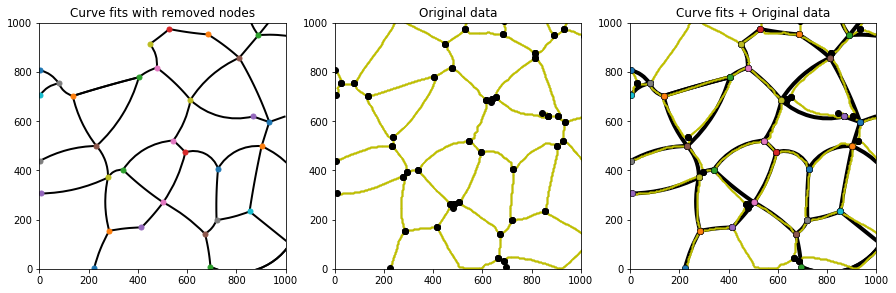

In [11]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

Potentially do more post processing here because it seems to run ito problems curve fitting stuff for larger cutoffs

Need to check that a node is connected to only 2 edges. In which case, delete it and replace the 2 edges with one edge

In [14]:
cells = []
max_iter = 40

for e in edges:
    cell = e.which_cell(edges, 1, max_iter)
    check = 0
    if cell != []:
        for c in cells:
            if set(cell.edges) == set(c.edges):
                check = 1
        if check == 0:
            cells.append(cell)

    cell = e.which_cell(edges, 0, max_iter)
    check = 0
    if cell != []:
        for c in cells:
            if set(cell.edges) == set(c.edges):
                check = 1
        if check == 0:
            cells.append(cell)

print(cells)


[<cell_describe.cell object at 0x1332c9dda0>, <cell_describe.cell object at 0x1332cefb38>, <cell_describe.cell object at 0x1332cef940>, <cell_describe.cell object at 0x13329f0da0>, <cell_describe.cell object at 0x1332a4bbe0>, <cell_describe.cell object at 0x1332cefeb8>, <cell_describe.cell object at 0x1332cefef0>, <cell_describe.cell object at 0x1332ceffd0>, <cell_describe.cell object at 0x1332cf00f0>]


In [16]:
print(cells[0].edges)

[<cell_describe.edge object at 0x122247d68>, <cell_describe.edge object at 0x1222499e8>, <cell_describe.edge object at 0x122249780>, <cell_describe.edge object at 0x1222492b0>, <cell_describe.edge object at 0x122249080>]


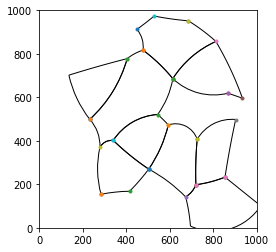

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.set_aspect(1)
ax.set(xlim = [0,1000], ylim = [0,1000])
[c.plot(ax) for c in cells]
plt.show()

# Can choose to ignore this

First, we check for nodes that are connected to a single edge with length less than a cutoff and delete them

In [8]:
# Choose a cutoff length

np.array([e.straight_length for n in nodes for e in n.edges if len(n.edges) == 1]).T

array([248.94376875,  79.61155695,  79.61155695,  45.17742799,
        60.5309838 , 102.5768005 , 187.08554193, 110.88733021,
       125.86500705,  50.20956084,  43.0464865 ,  65.60487787,
        29.73213749, 116.        ,  84.20213774, 163.68261972,
       281.26144421, 127.14165328, 183.46934349])

In [43]:
# Seems like theres a few nodes that are connected to a single edge with a length smaller than a cutoff
# Lets do another round of processing to eliminate this

# Cutoff length to ignore edges connected a single node
cutoff2 = 73
ind_node, ind_edge = [], []

for n in nodes:
    if len(n.edges) == 1:
        e = n.edges[0]
        
        if e.straight_length < cutoff2:
            ind_node.append(nodes.index(n))
            ind_edge.append(edges.index(e))
            
            # Delete this edge and associated tension vector from the other node
            
            other_node = e.nodes.difference([n]).pop()
            
            
            other_node.tension_vectors.pop(other_node.edges.index(e))
            

            other_node.edges.remove(e)
           

            
            

# Delete all the bad nodes 
print('Before')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

for index in sorted(ind_node, reverse=True):
    del nodes[index]
    
# Delete all the bad edges
for index in sorted(ind_edge, reverse=True):
    del edges[index]

print('After')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes)) 

Before
Number of branches is  62
Number of nodes is  53
After
Number of branches is  56
Number of nodes is  47


Plot to check

Number of branches is  69
Number of nodes is  59


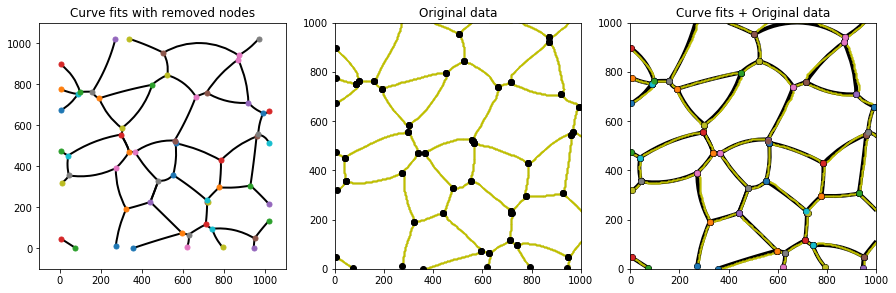

In [9]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [-100,1100], ylim = [-100,1100], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

# Cell finding

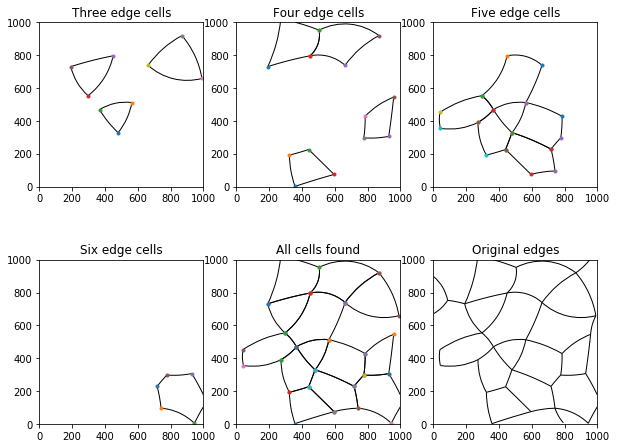

In [9]:
# Perform cell finding code. Output is cells
#type specifies direction of cell finding. 0 for minimum positive angle and 1 for maximum negative angle
# both types are implemented
# num specifies the final node (node_b if we start from node_a)
from main import main

type = 0
num = 1
cells = []

for ed in edges:
    con_edges0 = ed.connected_edges[0]
    angles1 = [ed.edge_angle(e2)  for e2 in con_edges0]
    cells = main(ed, angles1, con_edges0, cells, type, num)
    type = 1
    cells = main(ed, angles1, con_edges0, cells, type, num)
    

# plot all cells

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,3,figsize=(10,8))
[cell.plot(axes[0, 0]) for cell in cells if len(cell.edges) == 3];
[cell.plot(axes[0, 1]) for cell in cells if len(cell.edges) == 4];
[cell.plot(axes[0,2]) for cell in cells if len(cell.edges) == 5];
[cell.plot(axes[1,0]) for cell in cells if len(cell.edges) == 6];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 3 or 4 or 5 or 6 or 7 or 8 or 9 or 10 ];
#[cell.plot(axes[2,1]) for cell in cell_seven];
[ed.plot(axes[1,2]) for ed in edges];

[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[1,:]]
[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[0,:]]
#[a.set(xlim=(-1,1), ylim=(-1, 1), aspect=1) for a in axes[2,:]]
axes[1,2].set_title("Original edges")
axes[0,0].set_title("Three edge cells")
axes[0,1].set_title("Four edge cells")
axes[0,2].set_title("Five edge cells")
axes[1,0].set_title("Six edge cells")
#axes[2,1].set_title("Seven edge cells")
axes[1,1].set_title("All cells found")
plt.show()

# Manually removing bad edges

In [10]:
print(cells[0])

{
}


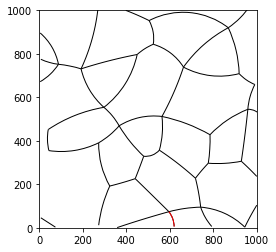

In [73]:
# Special case 1 - an edge between 2 nodes not connected to anything else

fig, ax = plt.subplots(1,1)
ax.set(xlim = [0, 1000], ylim = [0,1000], aspect = 1)
[e.plot(ax) for e in edges]
[e.plot(ax, color = 'r') for e in edges[2:3]]
plt.show()

In [45]:
node1 = edges[2].node_a
node2 = edges[2].node_b
nodes.remove(node1)
nodes.remove(node2)
edges.remove(edges[2])

# Pressure and Tension calculation

In [9]:
# Define colony and calculate tension. Then use that to find pressure

from cell_describe import colony 

col1 = colony(cells, edges, nodes)

# A and B are the matrices. Tensions and pressures are values for each edge and cell respectively 

tensions, P_T = col1.calculate_tension()

# pressures, B, rhs = col1.calculate_pressure(tensions)

In [10]:
pressures, P_P = col1.calculate_pressure(tensions)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 5.08773879e-04]
 [ 5.74481461e-04]
 [-5.08773879e-04]
 [ 6.85183328e-04]
 [-5.74481461e-04]
 [ 1.91985751e-07]
 [-6.85183328e-04]
 [-5.41404894e-04]
 [-6.57230697e-05]
 [-1.91985751e-07]
 [ 5.41404894e-04]
 [ 5.90480303e-03]
 [ 6.57230697e-05]
 [-5.90480303e-03]]


../cell_soap/cell_describe.py:529: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.032090e-18
  x = linalg.solve(R2, y) # Solve Rx=y


In [18]:
Q = np.ones((10,1))
A = np.ones((14,1))
Q[0:8, 0] = A[0:8,0]

Mean value of tension is ->  2.6082637553417913e-17
Mean value of pressure is ->  -7.003381615953585e-35
Condition number for tension matrix is  ->  6.382454089735468e+16
Condition number for Pressure matrix is  ->  8.59979981184484


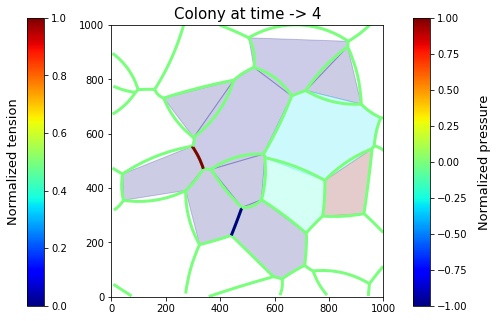

In [62]:
# plot tension and pressures on a single plot

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.colors import Normalize
import matplotlib as mpl

# Get edges from colony
edges2 = col1.tot_edges
nodes2 = col1.nodes
# edges2 = edges
# nodes2 = nodes
fig, ax = plt.subplots(1,1,figsize=(8,5))


# Normalize pressures and tensions

min_t = min(tensions)
max_t = max(tensions)

def norm(tensions):
    return (tensions - min_t) / float(max_t - min_t)
    #return (tensions - np.mean(tensions))/float(np.std(tensions))

new = norm(tensions)

min_p = min(pressures)
max_p = max(pressures)

def norm(pressures):
    #return (pressures - min_p) / float(max_p - min_p)
    return (pressures - np.mean(pressures))/float(np.std(pressures))

new2 = norm(pressures)

# Plot pressures

for j, c in enumerate(cells):
    x = [n.loc[0] for n in c.nodes]
    y = [n.loc[1] for n in c.nodes]
    plt.fill(x, y, c= cm.jet(new2[j]), alpha = 0.2)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=-1, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)  
cl.set_label('Normalized pressure', fontsize = 13, labelpad = 10)

# Plot tensions

for j, an_edge in enumerate(edges2):
    an_edge.plot(ax, edgecolor = cm.jet(new[j]), lw = 3)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.13, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)
cl.set_label('Normalized tension', fontsize = 13, labelpad = -60)

ax.set(xlim=[0,1000], ylim=[0, 1000], aspect = 1)
ax.set_title('Colony at time -> %d' %t, fontsize = 15)

# Check mean values of tension and pressure

# Should be 1
print('Mean value of tension is -> ', np.mean(tensions))

# Should be 0
print('Mean value of pressure is -> ', np.mean(pressures))

# Check condition numbers 
# Should be small 

print('Condition number for tension matrix is  -> ', np.linalg.cond(P_T))
print('Condition number for Pressure matrix is  -> ', np.linalg.cond(P_P))

array([-0.78335225, -1.5317741 , -0.51985508, -0.41762886, -0.31201998,
       -0.97780796, -0.72792868, -0.32802608, -0.53863723, -1.63950931,
       -0.43221893, -0.47282854, -0.21160647, -0.63201271,  3.425885  ,
        3.00133079,  2.00112383,  1.36285064, -0.54729829, -0.46453666,
       -0.43048569,  0.46348184,  1.97485827, -0.56971548, -0.48650532,
       -0.25613837, -0.36092892, -0.54997594, -0.47950238,  1.03024759,
       -0.37486872, -0.3706236 , -0.43431948, -0.32978484, -0.10061574,
       -0.24567366, -0.27744472,  1.02444111,  0.22613419,  1.02460914,
        0.8020773 , -0.91579157, -0.47417986,  1.13655138, -0.02091614,
        0.89085559, -0.30042095, -0.57232988,  1.13647109, -0.51803923,
       -0.09140274, -0.80421339])

In [17]:
np.mean(tensions)

1.0000000000000002

In [18]:
np.mean(pressures)

-6.406649201050708e-20

In [19]:
pressures

array([ 8.58869928e-04,  3.39056259e-04, -9.25351821e-05,  4.54413422e-04,
       -8.45999782e-04, -7.57115992e-06,  8.02880413e-04, -5.68183251e-04,
        1.61587153e-04, -7.90483117e-04, -3.12034683e-04])

In [119]:
import numpy as np
def lse(A, b, B, d, cond=None):
    """
    Equality-contrained least squares.The following algorithm minimizes
    ||Ax - b|| subject to the constrain Bx = d.

    Parameters
    ----------
    A : array-like, shape=[m, n]
    b : array-like, shape=[m]
    B : array-like, shape=[p, n]
    d : array-like, shape=[p]
    cond : float, optional Cutoff for 'small' singular
    values; used to determine effective rank of A. Singular values smaller
    than rcond largest singular value are considered zero.

    Reference
    ---------
    Matrix Computations, Golub & van Loan, algorithm 12.1.2

    Examples
    --------
    >>> A, b = [[0, 2, 3], [1, 3, 4.5]], [1, 1]
    >>> B, d = [[1, 1, 0]], [1]
    >>> lse(A, b, B, d) array([-0.5 , 1.5 , -0.66666667])
    """
    from scipy import linalg
    if not hasattr(linalg, 'solve_triangular'): # compatibility for old scipy
        def solve_triangular(X, y, **kwargs):
            return linalg.solve(X, y)
    else:
        solve_triangular = linalg.solve_triangular
    A, b, B, d = map(np.asanyarray, (A, b, B, d))
    p = B.shape[0]
    
    Q, R = linalg.qr(B.T)
    print(R[:p,:p])
    print(d)
    y = solve_triangular(R[:p, :p], d, trans='T', lower=False)
    print(y)
    A = np.dot(A, Q)
    z = linalg.lstsq(A[:, p:], b - np.dot(A[:, :p], y), cond=cond)[0].ravel()
    return np.dot(Q[:, :p], y) + np.dot(Q[:, p:], z)

In [100]:
A = np.random.rand(3,2)

In [104]:
b = np.random.rand(3)

In [105]:
B = np.random.rand(3,2)

In [106]:
d = np.random.rand(3)

In [120]:
lse(A, b, B, d)

[[-0.9590655  -0.12602002 -0.91139049]
 [ 0.          0.3863926   0.01517065]]
[0.85953275 0.63783006 0.93475035]


ValueError: expected square matrix

In [127]:
A = np.random.rand(8,4)
A1 = np.dot(A.T, A)

In [126]:
np.shape(np.dot(A.T, A))

(4, 4)

In [128]:
C = np.ones(4)

array([1., 1., 1., 1.])

In [134]:
AA = np.array(([A1,C.T],[C,0]))

In [136]:
np.shape(AA)

(2, 2)

In [141]:
BB = np.zeros((5,1))

In [145]:
BB[4,0] = 4

In [146]:
BB

array([[0.],
       [0.],
       [0.],
       [0.],
       [4.]])

In [147]:
np.shape(BB)

(5, 1)

In [151]:
#import linalg package of the SciPy module for the LU decomp 
import scipy.linalg as linalg 
#import NumPy 
import numpy as np 

#call the lu_factor function 
Q, R = linalg.qr(AA)


ValueError: setting an array element with a sequence.

In [152]:
N = np.ones((5,5))

In [160]:
A1

array([[2.70448226, 1.70487973, 2.09568136, 1.861307  ],
       [1.70487973, 2.59813583, 2.07897666, 1.51454654],
       [2.09568136, 2.07897666, 3.75960227, 2.09999377],
       [1.861307  , 1.51454654, 2.09999377, 2.29187346]])

In [156]:
N[0,:]

array([1., 1., 1., 1., 1.])

In [181]:
N[0:4, 0:4] = A1


In [182]:
N

array([[2.70448226, 1.70487973, 2.09568136, 1.861307  , 1.        ],
       [1.70487973, 2.59813583, 2.07897666, 1.51454654, 1.        ],
       [2.09568136, 2.07897666, 3.75960227, 2.09999377, 1.        ],
       [1.861307  , 1.51454654, 2.09999377, 2.29187346, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ]])

In [162]:
N

array([[2.70448226, 1.70487973, 2.09568136, 1.861307  , 1.        ],
       [1.70487973, 2.59813583, 2.07897666, 1.51454654, 1.        ],
       [2.09568136, 2.07897666, 3.75960227, 2.09999377, 1.        ],
       [1.861307  , 1.51454654, 2.09999377, 2.29187346, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [165]:
N[4,4] = 0

In [166]:
N

array([[2.70448226, 1.70487973, 2.09568136, 1.861307  , 1.        ],
       [1.70487973, 2.59813583, 2.07897666, 1.51454654, 1.        ],
       [2.09568136, 2.07897666, 3.75960227, 2.09999377, 1.        ],
       [1.861307  , 1.51454654, 2.09999377, 2.29187346, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ]])

In [169]:
B = np.zeros((5,1))
B[4,0] = 4
B

array([[0.],
       [0.],
       [0.],
       [0.],
       [4.]])

In [170]:
Q, R = linalg.qr(N) # QR decomposition with qr function
y = np.dot(Q.T, B) # Let y=Q'.B using matrix multiplication
x = linalg.solve(R, y) # Solve Rx=y

In [171]:
x

array([[ 0.70747413],
       [ 1.59777282],
       [-0.4010051 ],
       [ 2.09575815],
       [-7.69783213]])

In [183]:
np.mean(x[0:4])

1.0

In [176]:
np.shape(A)[1]

4

In [184]:
x[0:4]

array([[ 0.70747413],
       [ 1.59777282],
       [-0.4010051 ],
       [ 2.09575815]])

In [19]:
def solve_constrained_lsq(A, type, B = None):
    """
    Solve constrained least square system PX = Q.  
    A is an M * N matrix comprising M equations and N unknowns 
    B is an N * 1 matrix comprising RHS of the equations
    Type specifies the Lagrange multiplier we use - 0 or 1
    For type 0 ->
    Define a matrix P = [[A^TA, C^T],[C, 0]]  - > (N + 1) * (N + 1) matrix
                    Q = [0..., N]  -> (N + 1) * 1 matrix
    For type 1 -> 
    Define a matrix P = [[A^TA, C^T],[C, 0]]  - > (N + 1) * (N + 1) matrix
                    Q = [B, 0]  -> (N + 1) * 1 matrix
    """

    # Get N - number of columns
    N = np.shape(A)[1]

    # Define matrix of ones
    P = np.ones((N + 1, N + 1))

    # Get A^TA
    A1 = np.dot(A.T, A)

    # Plug this into appropriate place in P 
    P[0:N, 0:N] = A1

    # Set last element in N,N position to 0 
    P[N, N] = 0

    if type == 0:
        # Define Q
        Q = np.zeros((N+1, 1))

        # Set last element to N (number of edges) 
        # Effectively says average value is 1
        Q[N, 0] = N

    if type == 1:
        # Define Q
        Q = np.zeros((N+1, 1))
        
        Q[0:N, 0] = B
        # Effectively says average is 0 
        Q[N, 0] = 0


    # Solve PX = Q
    R1, R2 = linalg.qr(P) # QR decomposition with qr function
    y = np.dot(R1.T, Q) # Let y=R1'.Q using matrix multiplication
    x = linalg.solve(R2, y) # Solve Rx=y

    return x[0:N]

In [20]:
A = np.random.rand(8,4)

In [21]:
B = np.random.rand(8,1)

In [22]:
#import linalg package of the SciPy module for the LU decomp 
import scipy.linalg as linalg 
#import NumPy 
import numpy as np 

x = solve_constrained_lsq(A, 0, B)

In [45]:
Q = np.zeros((4+1, 1))

In [59]:
Q[0:4, 0] = B[0:4]

In [26]:
x[:,0][0]

2.8621969391038315

In [57]:
B

array([0.49354662, 0.60382313, 0.38775624, 0.75702944, 0.29573665,
       0.8911386 , 0.69028256, 0.85292617])

TypeError: 'edge' object does not support indexing

In [9]:
ax.plot